In [1]:
import os
import sys
import numpy as np
import pandas as pd
import scipy as sp
import scipy.linalg
from fixed_point_sol import *
from generate_data import *
from compute_risk import *
from tqdm import tqdm

In [2]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Ridge in $\lambda$

In [3]:
path_result = 'result/ex1/'
method ='ridge'

n_simu = 50
rho_ar1 = 0.25
phi = 0.2

sigma = 1.
df_emp = pd.DataFrame()
for i in np.arange(50):
    for psi in [0.5,1.5]:
        try:
            _df = pd.read_csv(
                path_result+'res_{}_phi_{:.01f}_psi_{:.01f}_sigma_{:.01f}_seed_{}.csv'.format(method, phi, psi, sigma, i))

            _df.columns = ['lam', 'seed','type']+np.char.add('risk-',np.arange(1,11).astype(str)).tolist() + ['phi','psi','rho2', 'sigma2']
            _df = pd.wide_to_long(_df, stubnames='risk', i=['lam', 'seed', 'type'], j='M', sep='-', suffix='\w+').reset_index()    
            df_emp = pd.concat([df_emp, _df], axis=0)
        except:
            continue

df_emp = df_emp[df_emp['lam'] != 1e-3]
df_emp.loc[df_emp['lam'] == 1e-8,'lam'] = 1e-3

df_emp['M'] = df_emp['M'].astype(str)

df_emp = df_emp.reset_index(drop=True)

['M', '1', '2', '5', 'type', 'risk_emp', 'cgcv_emp', 'gcv_emp']


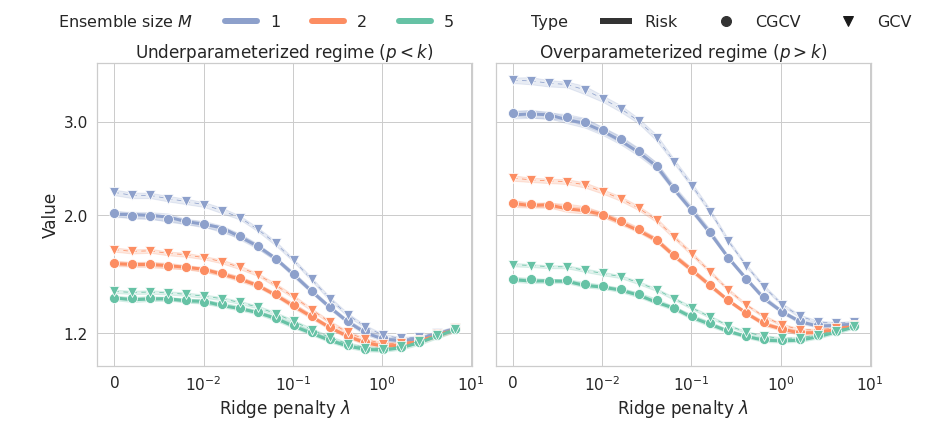

In [4]:
sns.set(font_scale=1.4)
sns.set_style("whitegrid")
fig, axes = plt.subplots(1,2, figsize=(12,6), sharey=True)

cm = sns.color_palette('magma_r', 3)

M_list = np.array([1,2,5], dtype=str)

for j, phi_s in enumerate([0.5, 1.5]):
    sns.lineplot(
        data=df_emp[df_emp['M'].isin(M_list) &(df_emp['psi']==phi_s) & (df_emp['lam'].isin(df_emp['lam'].unique()[::10]))], 
        x='lam', y='risk', palette=sns.color_palette("Set2", len(M_list))[::-1],# errorbar=None,
         hue='M', hue_order=M_list, 
        style='type', style_order=['risk_emp','cgcv_emp','gcv_emp'], dashes=[(1,0),(0,1),(6,6)],
        markers=['.', 'o', 'v'], markersize=10, 
        size='type', size_order=['risk_emp','cgcv_emp','gcv_emp'],
        ax=axes[j], 
    )
    axes[j].set_xscale('log')
    axes[j].set_yscale('log')
    axes[j].set_xlabel('Ridge penalty $\lambda$')
    if j==0:
        axes[j].set_ylabel('Value')
    else:
        axes[j].set_ylabel('')


for j in range(2):
    axes[j].set_xticks([])
    axes[j].set_xticks([], minor=True)
    ticks = 10.**np.arange(-3,2,1)
    axes[j].set_xticks(ticks)
    axes[j].set_xticklabels(['0'] + ['$10^{{{:d}}}$'.format(i) for i in np.arange(-2,2,1)])
    
j = 0
axes[j].set_yticks([])
axes[j].set_yticks([], minor=True)
ticks = [1.2, 2., 3.]
axes[j].set_yticks(ticks)
axes[j].set_yticklabels(['{:.01f}'.format(i) for i in ticks])

axes[0].set_title('Underparameterized regime ($p<k$)')
axes[1].set_title('Overparameterized regime ($p>k$)')


lines_labels = [ax.get_legend_handles_labels() for ax in [axes[0]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
_, indices = np.unique(labels, return_index=True)
print(labels)
for j in range(2):
    axes[j].get_legend().remove()
labels[0] = 'Ensemble size $M$'
labels[4:] = ['Type', 'Risk', 'CGCV', 'GCV']
handles[-1] = mlines.Line2D([], [], color='k', marker='v', linestyle='None',
                              markersize=10)
legend = fig.legend(handles=handles, labels=labels,
                    loc=9, ncol=10, title='', frameon=False, fontsize=16)

def legend_title_left(leg):
    c = leg.get_children()[0]
    title = c.get_children()[0]
    hpack = c.get_children()[1]
    c._children = [hpack]
    hpack._children = [title] + hpack.get_children()
legend_title_left(legend)

for item, label in zip(legend.legendHandles, legend.texts):
    if label.get_text()=='Risk':
        item.set_linewidth(6)
    elif label.get_text()=='CGCV' or label.get_text()=='GCV':
        item.set_linewidth(2)
        item.set_markersize(10)
    else:
        item.set_linewidth(6)
        
    label.set_ha('left')
fig.tight_layout()
fig.subplots_adjust(top=0.85)
plt.savefig('result/fig_ridge_lam.pdf', bbox_inches='tight', pad_inches=0, dpi=300)    

# Ridge in $\lambda$

['lam', '0.001', '0.0977124153534649', '0.9884959046625588', 'type', 'risk_emp', 'cgcv_emp', 'gcv_emp']


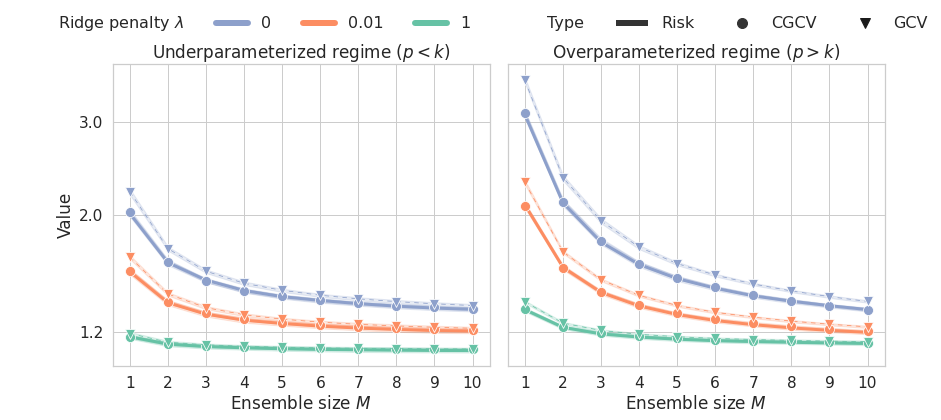

In [5]:
sns.set(font_scale=1.4)
sns.set_style("whitegrid")
fig, axes = plt.subplots(1,2, figsize=(12,6), sharey=True
                        )

cm = sns.color_palette('magma_r', 3)

uni_lam_list = df_emp['lam'].unique()

lam_list = np.array([1e-3,
                     uni_lam_list[np.argmin(np.abs(uni_lam_list-1e-1))],
                     uni_lam_list[np.argmin(np.abs(uni_lam_list-1e0))]
                    ])

for j, phi_s in enumerate([0.5, 1.5]):

    _df = df_emp[df_emp['lam'].isin(lam_list) &(df_emp['psi']==phi_s)]
    _df['lam'] = _df['lam'].astype(str)

    sns.lineplot(
        data=_df, 
        x='M', y='risk', palette=sns.color_palette("Set2", len(M_list))[::-1], #errorbar=None,
         hue='lam', #hue_order=M_list, 
        style='type', style_order=['risk_emp','cgcv_emp','gcv_emp'], dashes=[(1,0),(0,1),(6,6)],
        markers=['.', 'o', 'v'], markersize=10, 
        size='type', size_order=['risk_emp','cgcv_emp','gcv_emp'],
        ax=axes[j], 
    )
    
    axes[j].set_yscale('log')
    axes[j].set_xlabel('Ensemble size $M$')
    if j==0:
        axes[j].set_ylabel('Value')
    else:
        axes[j].set_ylabel('')

    
j = 1
axes[j].set_yticks([])
axes[j].set_yticks([], minor=True)
ticks = [1.2, 2., 3.]
axes[j].set_yticks(ticks)
axes[j].set_yticklabels(['{:.01f}'.format(i) for i in ticks])

axes[0].set_title('Underparameterized regime ($p<k$)')
axes[1].set_title('Overparameterized regime ($p>k$)')


lines_labels = [ax.get_legend_handles_labels() for ax in [axes[0]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
_, indices = np.unique(labels, return_index=True)
print(labels)
for j in range(2):
    axes[j].get_legend().remove()
labels[0] = 'Ridge penalty $\lambda$'
labels[1:3] = ['0','0.01','1']
labels[4:] = ['Type', 'Risk', 'CGCV', 'GCV']
handles[-1] = mlines.Line2D([], [], color='k', marker='v', linestyle='None',
                              markersize=10)
legend = fig.legend(handles=handles, labels=labels,
                    loc=9, ncol=10, title='', frameon=False, fontsize=16)

def legend_title_left(leg):
    c = leg.get_children()[0]
    title = c.get_children()[0]
    hpack = c.get_children()[1]
    c._children = [hpack]
    hpack._children = [title] + hpack.get_children()
legend_title_left(legend)

for item, label in zip(legend.legendHandles, legend.texts):
    if label.get_text()=='Risk':
        item.set_linewidth(6)
    elif label.get_text()=='CGCV' or label.get_text()=='GCV':
        item.set_linewidth(2)
        item.set_markersize(10)
    else:
        item.set_linewidth(6)
        
    label.set_ha('left')
fig.tight_layout()
fig.subplots_adjust(top=0.85)
plt.savefig('result/fig_ridge_M.pdf', bbox_inches='tight', pad_inches=0, dpi=300)    

# Lasso in $\lambda$

In [6]:
path_result = 'result/ex1/'
method = 'lasso'
n_simu = 50
rho_ar1 = 0.25
phi = 0.2

sigma = 1.
df_emp = pd.DataFrame()
for i in np.arange(50):
    for psi in [0.5,1.5]:
        try:
            _df = pd.read_csv(
                path_result+'res_{}_phi_{:.01f}_psi_{:.01f}_sigma_{:.01f}_seed_{}.csv'.format(method, phi, psi, sigma, i))

            _df.columns = ['lam', 'seed','type']+np.char.add('risk-',np.arange(1,11).astype(str)).tolist() + ['phi','psi','rho2', 'sigma2']
            _df = pd.wide_to_long(_df, stubnames='risk', i=['lam', 'seed', 'type'], j='M', sep='-', suffix='\w+').reset_index()    
            df_emp = pd.concat([df_emp, _df], axis=0)
        except:
            continue

df_emp = df_emp[df_emp['lam'] != 1e-8]

df_emp['M'] = df_emp['M'].astype(str)

df_emp = df_emp.reset_index(drop=True)

['M', '1', '2', '5', 'type', 'risk_emp', 'cgcv_emp', 'gcv_emp']


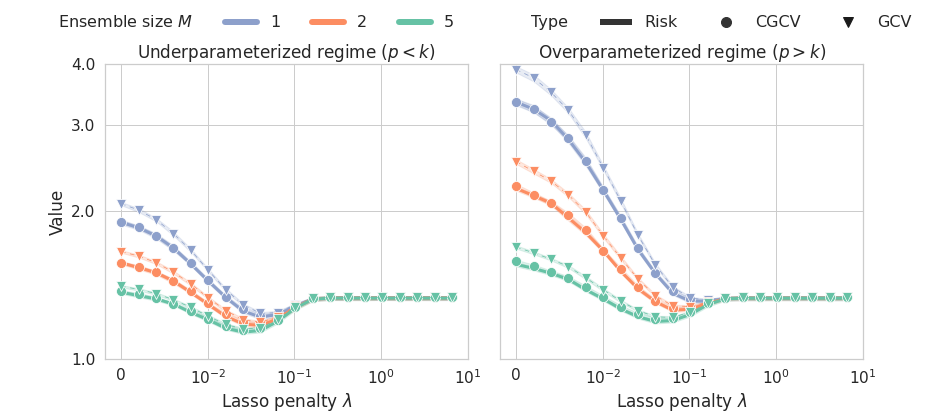

In [7]:
sns.set(font_scale=1.4)
sns.set_style("whitegrid")
fig, axes = plt.subplots(1,2, figsize=(12,6), sharey=True)

cm = sns.color_palette('magma_r', 3)

M_list = np.array([1,2,5], dtype=str)

for j, phi_s in enumerate([0.5, 1.5]):
    sns.lineplot(
        data=df_emp[df_emp['M'].isin(M_list) & (df_emp['psi']==phi_s) & (df_emp['lam'].isin(df_emp['lam'].unique()[::10]))], 
        x='lam', y='risk', palette=sns.color_palette("Set2", len(M_list))[::-1], #errorbar=None,
         hue='M', hue_order=M_list, 
        style='type', style_order=['risk_emp','cgcv_emp','gcv_emp'], dashes=[(1,0),(0,1),(6,6)],
        markers=['.', 'o', 'v'], markersize=10, 
        size='type', size_order=['risk_emp','cgcv_emp','gcv_emp'],
        ax=axes[j],
    )
      
    axes[j].set_xscale('log')
    axes[j].set_yscale('log')
    axes[j].set_xlabel('Lasso penalty $\lambda$')
    if j==0:
        axes[j].set_ylabel('Value')
    else:
        axes[j].set_ylabel('')

axes[1].set_ylim([1,4])
for j in range(2):
    axes[j].set_xticks([])
    axes[j].set_xticks([], minor=True)
    ticks = 10.**np.arange(-3,2,1)
    axes[j].set_xticks(ticks)
    axes[j].set_xticklabels(['0'] + ['$10^{{{:d}}}$'.format(i) for i in np.arange(-2,2,1)])
    
j = 0
axes[j].set_yticks([])
axes[j].set_yticks([], minor=True)
ticks = [1., 2., 3., 4]
axes[j].set_yticks(ticks)
axes[j].set_yticklabels(['{:.01f}'.format(i) for i in ticks])

axes[0].set_title('Underparameterized regime ($p<k$)')
axes[1].set_title('Overparameterized regime ($p>k$)')


lines_labels = [ax.get_legend_handles_labels() for ax in [axes[0]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
_, indices = np.unique(labels, return_index=True)
print(labels)
for j in range(2):
    axes[j].get_legend().remove()
labels[0] = 'Ensemble size $M$'
labels[4:] = ['Type', 'Risk', 'CGCV', 'GCV']
handles[-1] = mlines.Line2D([], [], color='k', marker='v', linestyle='None',
                              markersize=10)
legend = fig.legend(handles=handles, labels=labels,
                    loc=9, ncol=10, title='', frameon=False, fontsize=16)

def legend_title_left(leg):
    c = leg.get_children()[0]
    title = c.get_children()[0]
    hpack = c.get_children()[1]
    c._children = [hpack]
    hpack._children = [title] + hpack.get_children()
legend_title_left(legend)

for item, label in zip(legend.legendHandles, legend.texts):
    if label.get_text()=='Risk':
        item.set_linewidth(6)
    elif label.get_text()=='CGCV' or label.get_text()=='GCV':
        item.set_linewidth(2)
        item.set_markersize(10)
    else:
        item.set_linewidth(6)
        
    label.set_ha('left')
fig.tight_layout()
fig.subplots_adjust(top=0.85)
plt.savefig('result/fig_lasso_lam.pdf', bbox_inches='tight', pad_inches=0, dpi=300)    

# Elastic net in $\lambda_1$

In [8]:
path_result = 'result/ex1/'
method = 'elastic_net'
n_simu = 50
rho_ar1 = 0.25
phi = 0.2

sigma = 1.
df_emp = pd.DataFrame()
for i in np.arange(50):
    for psi in [0.5,1.5]:
        try:
            _df = pd.read_csv(
                path_result+'res_{}_phi_{:.01f}_psi_{:.01f}_sigma_{:.01f}_seed_{}.csv'.format(method, phi, psi, sigma, i))

            _df.columns = ['lam', 'seed','type']+np.char.add('risk-',np.arange(1,11).astype(str)).tolist() + ['phi','psi','rho2', 'sigma2']
            _df = pd.wide_to_long(_df, stubnames='risk', i=['lam', 'seed', 'type'], j='M', sep='-', suffix='\w+').reset_index()    
            df_emp = pd.concat([df_emp, _df], axis=0)
        except:
            continue

df_emp = df_emp[df_emp['lam'] != 1e-8]

df_emp['M'] = df_emp['M'].astype(str)

df_emp = df_emp.reset_index(drop=True)

['M', '1', '2', '5', 'type', 'risk_emp', 'cgcv_emp', 'gcv_emp']


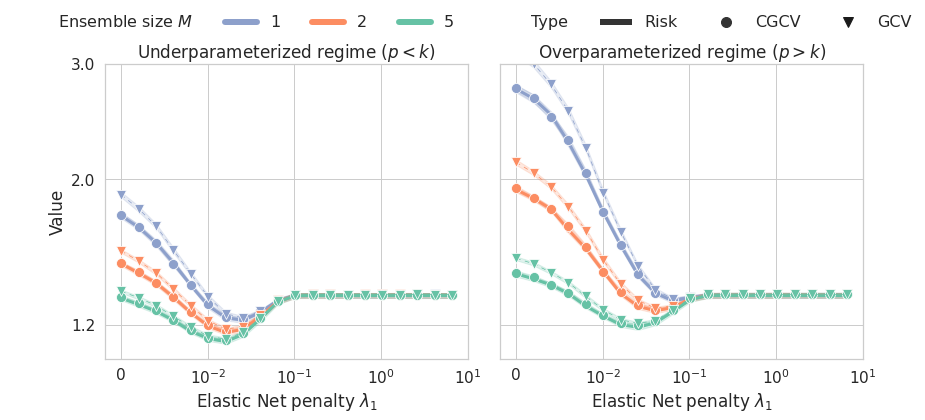

In [9]:
sns.set(font_scale=1.4)
sns.set_style("whitegrid")
fig, axes = plt.subplots(1,2, figsize=(12,6), sharey=True)

cm = sns.color_palette('magma_r', 3)

M_list = np.array([1,2,5], dtype=str)

for j, phi_s in enumerate([0.5, 1.5]):
    sns.lineplot(
        data=df_emp[df_emp['M'].isin(M_list) &(df_emp['psi']==phi_s) & (df_emp['lam'].isin(df_emp['lam'].unique()[::10]))], 
        x='lam', y='risk', palette=sns.color_palette("Set2", len(M_list))[::-1],# errorbar=None,
         hue='M', hue_order=M_list, 
        style='type', style_order=['risk_emp','cgcv_emp','gcv_emp'], dashes=[(1,0),(0,1),(6,6)],
        markers=['.', 'o', 'v'], markersize=10, 
        size='type', size_order=['risk_emp','cgcv_emp','gcv_emp'],
        ax=axes[j], 
    )
    axes[j].set_xscale('log')
    axes[j].set_yscale('log')
    axes[j].set_xlabel('Elastic Net penalty $\lambda_1$')
    if j==0:
        axes[j].set_ylabel('Value')
    else:
        axes[j].set_ylabel('')


for j in range(2):
    axes[j].set_xticks([])
    axes[j].set_xticks([], minor=True)
    ticks = 10.**np.arange(-3,2,1)
    axes[j].set_xticks(ticks)
    axes[j].set_xticklabels(['0'] + ['$10^{{{:d}}}$'.format(i) for i in np.arange(-2,2,1)])
    
j = 0
axes[j].set_ylim([0,3])

axes[j].set_yticks([])
axes[j].set_yticks([], minor=True)
ticks = [1.2, 2., 3.]
axes[j].set_yticks(ticks)
axes[j].set_yticklabels(['{:.01f}'.format(i) for i in ticks])

axes[0].set_title('Underparameterized regime ($p<k$)')
axes[1].set_title('Overparameterized regime ($p>k$)')


lines_labels = [ax.get_legend_handles_labels() for ax in [axes[0]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
_, indices = np.unique(labels, return_index=True)
print(labels)
for j in range(2):
    axes[j].get_legend().remove()
labels[0] = 'Ensemble size $M$'
labels[4:] = ['Type', 'Risk', 'CGCV', 'GCV']
handles[-1] = mlines.Line2D([], [], color='k', marker='v', linestyle='None',
                              markersize=10)
legend = fig.legend(handles=handles, labels=labels,
                    loc=9, ncol=10, title='', frameon=False, fontsize=16)

def legend_title_left(leg):
    c = leg.get_children()[0]
    title = c.get_children()[0]
    hpack = c.get_children()[1]
    c._children = [hpack]
    hpack._children = [title] + hpack.get_children()
legend_title_left(legend)

for item, label in zip(legend.legendHandles, legend.texts):
    if label.get_text()=='Risk':
        item.set_linewidth(6)
    elif label.get_text()=='CGCV' or label.get_text()=='GCV':
        item.set_linewidth(2)
        item.set_markersize(10)
    else:
        item.set_linewidth(6)
        
    label.set_ha('left')
fig.tight_layout()
fig.subplots_adjust(top=0.85)
plt.savefig('result/fig_{}_lam.pdf'.format(method), bbox_inches='tight', pad_inches=0, dpi=300)    

# Ridge and Lasso in $\psi$

In [10]:
path_result = 'result/ex1/'


n_simu = 50
rho_ar1 = 0.25
phi = 0.2

sigma = 1.
df_emp = pd.DataFrame()
for i in np.arange(50):
    for method in  ['ridge','lasso']:
        try:
            _df = pd.read_csv(
                path_result+'res_{}_phi_{:.01f}_sigma_{:.01f}_seed_{}.csv'.format(
                method, phi, sigma, i))

            _df.columns = ['psi', 'seed','type']+np.char.add('risk-',np.arange(1,11).astype(str)).tolist() + ['phi', 'lam','rho2', 'sigma2']
            _df = pd.wide_to_long(_df, stubnames='risk', i=['psi', 'seed', 'type'], j='M', sep='-', suffix='\w+').reset_index()
            _df['method'] = method
            df_emp = pd.concat([df_emp, _df], axis=0)
        except:
            continue

df_emp['M'] = df_emp['M'].astype(str)

df_emp = df_emp.reset_index(drop=True)

['M', '1', '2', '5', 'type', 'risk_emp', 'cgcv_emp', 'gcv_emp']


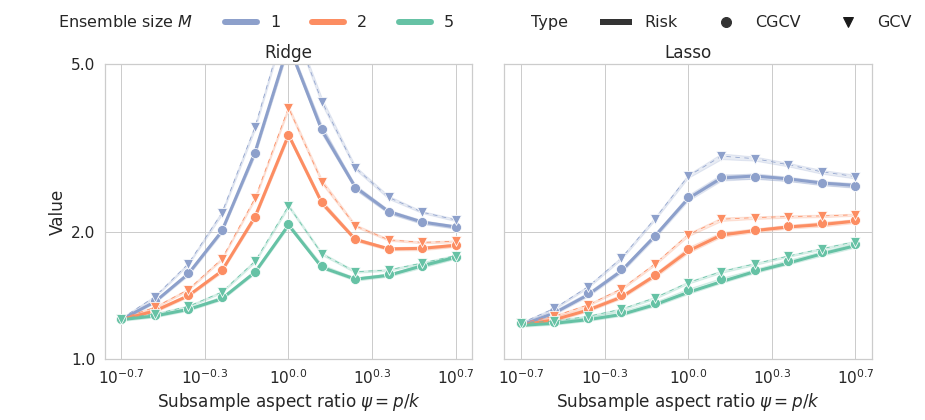

In [11]:
sns.set(font_scale=1.4)
sns.set_style("whitegrid")
fig, axes = plt.subplots(1,2, figsize=(12,6), sharey=True)

cm = sns.color_palette('magma_r', 3)

M_list = np.array([1,2,5], dtype=str)

for j, method in enumerate(['ridge','lasso']):
    sns.lineplot(
        data=df_emp[df_emp['M'].isin(M_list) &(df_emp['method']==method)
                    & (df_emp['psi'].isin(df_emp['psi'].unique()[::10]))
                   ], 
        x='psi', y='risk', palette=sns.color_palette("Set2", len(M_list))[::-1], #errorbar=None,
         hue='M', hue_order=M_list, 
        style='type', style_order=['risk_emp','cgcv_emp','gcv_emp'], dashes=[(1,0),(0,1),(6,6)],
        markers=['.', 'o', 'v'], markersize=10, 
        size='type', size_order=['risk_emp','cgcv_emp','gcv_emp'],
        ax=axes[j], 
    )
    
    
    axes[j].set_xscale('log')
    axes[j].set_yscale('log')
    axes[j].set_xlabel('Subsample aspect ratio $\psi=p/k$')
    if j==0:
        axes[j].set_ylabel('Value')
    else:
        axes[j].set_ylabel('')


    axes[j].set_ylim([1.,5])

for j in range(2):
    axes[j].set_xticks([])
    axes[j].set_xticks([], minor=True)
    ticks = np.logspace(np.log10(phi), np.log10(5), 5)#10.**np.arange(-1,2,1)
    axes[j].set_xticks(ticks)
    axes[j].set_xticklabels(['$10^{{{:.01f}}}$'.format(i) for i in np.linspace(np.log10(phi), np.log10(5), 5)])

j = 0
axes[j].set_yticks([])
axes[j].set_yticks([], minor=True)
ticks = [1., 2, 5.]
axes[j].set_yticks(ticks)
axes[j].set_yticklabels(['{:.01f}'.format(i) for i in ticks])

axes[0].set_title('Ridge')
axes[1].set_title('Lasso')


lines_labels = [ax.get_legend_handles_labels() for ax in [axes[0]]]
handles, labels = [sum(lol, []) for lol in zip(*lines_labels)]
_, indices = np.unique(labels, return_index=True)
print(labels)
for j in range(2):
    axes[j].get_legend().remove()
labels[0] = 'Ensemble size $M$'
labels[4:] = ['Type', 'Risk', 'CGCV', 'GCV']
handles[-1] = mlines.Line2D([], [], color='k', marker='v', linestyle='None',
                              markersize=10)
legend = fig.legend(handles=handles, labels=labels,
                    loc=9, ncol=10, title='', frameon=False, fontsize=16)

def legend_title_left(leg):
    c = leg.get_children()[0]
    title = c.get_children()[0]
    hpack = c.get_children()[1]
    c._children = [hpack]
    hpack._children = [title] + hpack.get_children()
legend_title_left(legend)

for item, label in zip(legend.legendHandles, legend.texts):
    if label.get_text()=='Risk':
        item.set_linewidth(6)
    elif label.get_text()=='CGCV' or label.get_text()=='GCV':
        item.set_linewidth(2)
        item.set_markersize(10)
    else:
        item.set_linewidth(6)
        
    label.set_ha('left')
fig.tight_layout()
fig.subplots_adjust(top=0.85)
plt.savefig('result/fig_psi.pdf', bbox_inches='tight', pad_inches=0, dpi=300)    